In [1]:
import torch  # PyTorch library
import torchvision.transforms as transforms  # transforms from torchvision for data preprocessing
import torchvision.datasets as datasets  # datasets from torchvision for loading data
from torch.utils.data import DataLoader  # DataLoader from PyTorch for batching and shuffling data
import matplotlib.pyplot as plt  # matplotlib for data visualization

In [2]:
train_dir = "Training"  # Directory path for training data
test_dir = "Testing"  # Directory path for testing data

basic_transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

In [39]:
# Load datasets with basic transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=basic_transform)

torch.Size([3, 512, 512])


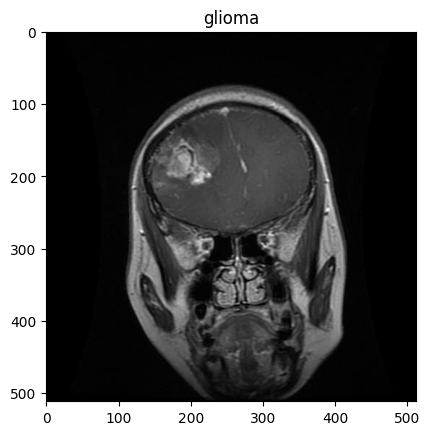

In [41]:
# Plot the first image as a sample
sample_img, sample_cls = train_dataset[0]
plt.imshow(sample_img.numpy().transpose(1, 2, 0))
# Add the title to indicate the class
plt.title(train_dataset.classes[sample_cls])
print(sample_img.shape)

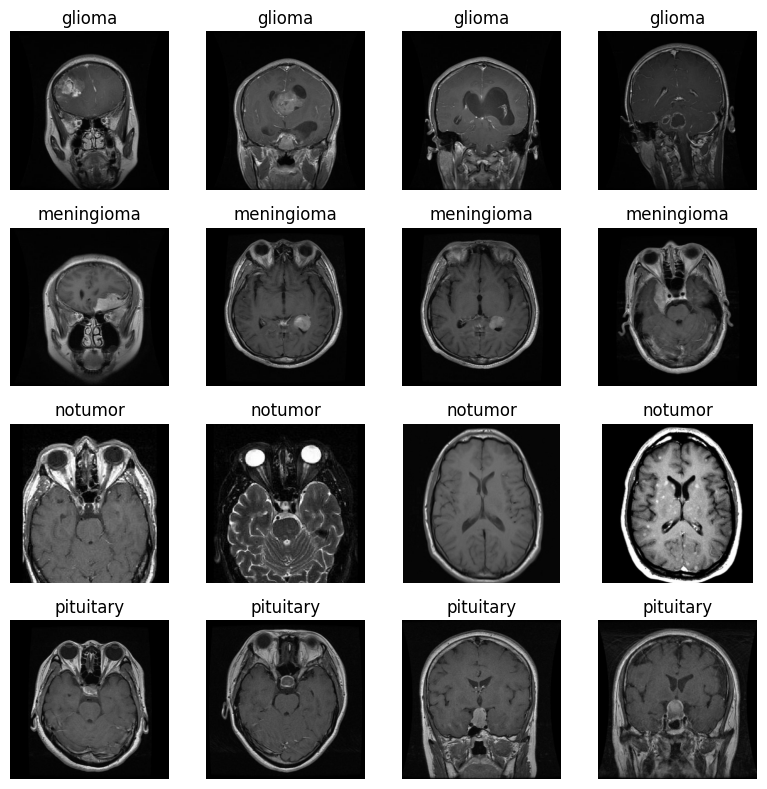

In [20]:
iterable_dataset = iter(train_dataset)
i = 0
sample_dict = {}
count_dict = {} 
plt.figure(figsize=(8, 8))

# Iterate through the dataset, count samples for each class, 
# and display up to 4 images per class
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset.classes[cls])
    plt.axis("off")

plt.tight_layout()

Text(0.5, 1.0, 'Frequency Distribution of classes')

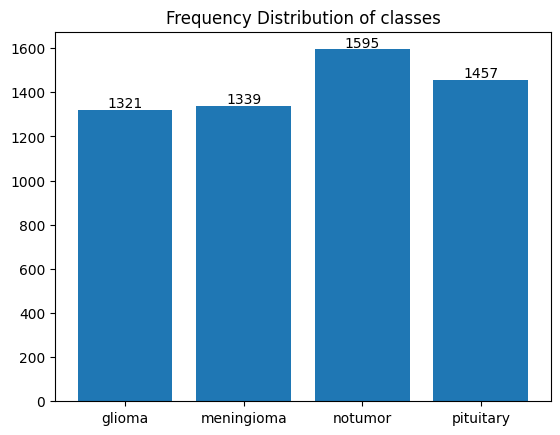

In [28]:
# Make a bar plot to indicate the frequency distribution
plt.bar(train_dataset.classes, count_dict.values())
for i, val in count_dict.items():
    plt.text(i, val + 10, val, ha="center")

plt.title("Frequency Distribution of classes")

In [29]:
# Create dataloaders with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [31]:
print(f"Training samples: {len(train_dataset)}, Training batches: {len(train_loader)}")
print(f"Testing samples: {len(test_dataset)}, Testing batches: {len(test_loader)}")

Training samples: 5712, Training batches: 179
Testing samples: 1311, Testing batches: 41


### Augmentation

In [52]:
general_transforms = {
    'train': transforms.Compose([
        # Data augmentation and transformation for training set
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.RandomResizedCrop(256, scale=(0.8, 1)),  # Randomly crop and resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # Transformation for testing set
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets with the defined transformations
train_dataset1 = datasets.ImageFolder(root=train_dir, transform=general_transforms['train'])
test_dataset1 = datasets.ImageFolder(root=test_dir, transform=general_transforms['test'])

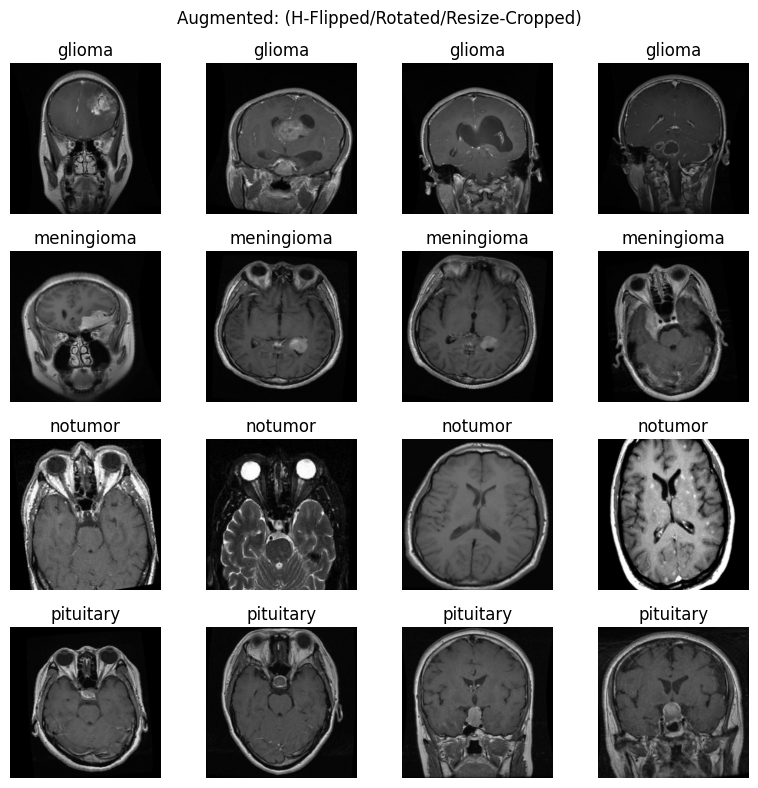

In [54]:
iterable_dataset = iter(train_dataset1)
i = 0
sample_dict = {}
count_dict = {} 
plt.figure(figsize=(8, 8))
while True:
    try:
        im, cls = next(iterable_dataset)
        count_dict.setdefault(cls, 0)
        count_dict[cls] += 1
    except StopIteration:
        break

    sample_dict.setdefault(cls, 0)
    if sample_dict[cls] >= 4:
        continue

    sample_dict[cls] += 1
    i += 1
    plt.subplot(4, 4, i)
    plt.imshow(im.numpy().transpose(1, 2, 0))
    plt.title(train_dataset1.classes[cls])
    plt.axis("off")

plt.suptitle("Augmented: (H-Flipped/Rotated/Resize-Cropped)")
plt.tight_layout()

### GAN

In [60]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512 * 8, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 8, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 4, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(512 * 2, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 256x256
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # 512x512
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # 256x256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 128x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 64x64
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512 * 2, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(512 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 2, 512 * 4, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(512 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 4, 512 * 8, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(512 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512 * 8, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()  # Output in the range [0, 1]
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available, otherwise use CPU
netG = Generator().to(device)  # Move the Generator model to the selected device
netD = Discriminator().to(device)  # Move the Discriminator model to the selected device

print(f"Using device: {device}")  # Print the device being used

Using device: cpu


In [58]:
from torch import optim

criterion = nn.BCELoss()  # Binary Cross-Entropy loss function
lr = 0.0001  # Learning rate for the optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr)  # Adam optimizer for the Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr)  # Adam optimizer for the Generator